# Анализ данных Яндекс.Афиши

**Цель исследования:**
- Сделать выводы по оптимизации расходов - определить наиболее эффективные/неэффективные

**Входные данные от сервиса Яндекс.Афиша:**
- Лог сервера с данными о посещениях сайта Яндекс.Афиши, выгрузка всех заказов за период с июня 2017 по май 2018, статистика рекламных расходов.

## 1. Обзор данных

In [40]:
import pandas as pd
import seaborn as sns
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt

In [28]:
pd.set_option('max_colwidth', 400)
sns.set(rc={'figure.figsize':(16, 7)})

In [4]:
visits = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/visits_log.csv')
orders = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/orders_log.csv')
costs = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/costs.csv')

### 1.1 Посещения сайта

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [8]:
visits.duplicated().sum()

0

In [15]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


- Дубликаты и пропуски не обнаружены. Нужно заменить формат даты/времени начала и конца сессии на правильный, переименую столбцы

### 1.2 Заказы с сайта

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [10]:
orders.duplicated().sum()

0

In [16]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


- Дубликаты и пропуски не обнаружены. Заменю формат даты/времени покупки на правильный, переименую столбцы

### 1.3 Траты на сайте

In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [9]:
costs.duplicated().sum()

0

In [18]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


- Дубликаты и пропуски не обнаружены. Заменю формат даты проведения рекламной компании на правильный

## 2. Предобработка данных

In [19]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format="%Y-%m-%d %H:%M")
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format="%Y-%m-%d %H:%M")

In [20]:
visits.rename(columns={'End Ts': 'session_end', 'Start Ts': 'session_start', 'Source Id': 'source_id'}, inplace=True)
visits.columns = map(str.lower, visits.columns)

In [21]:
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format = "%Y-%m-%d %H:%M")

In [22]:
orders.rename(columns={'Buy Ts': 'purchase_time'}, inplace=True)
orders.columns = map(str.lower, orders.columns)

In [23]:
costs['dt'] = costs['dt'].astype('datetime64')

**Промежуточный вывод**

Все данные приведены в соответствующий формат. Единицы измерения затрат и расходов - у.е. 

## 3. Расчет метрик и постройка графиков

### 3.1 Продуктовые метрики

#### 3.1.1 DAU, WAU, MAU

Рассчитаю количество уникальных пользователей в день, неделю и месяц, предварительно выделив в отдельные столбцы месяц, год, неделю и день первого подключения

In [24]:
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date
visits['session_day'] = visits['session_start'].dt.day

In [25]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'})
wau = (visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}))
mau = (visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}))

Рассчитаю среднее показателей

In [26]:
print('Количество уникальных пользователей в день:', dau.mean().astype('int'))
print('Количество уникальных пользователей в неделю:', wau.mean().astype('int'))
print('Количество уникальных пользователей в месяц:', mau.mean().astype('int'))

Количество уникальных пользователей в день: uid    907
dtype: int64
Количество уникальных пользователей в неделю: uid    5716
dtype: int64
Количество уникальных пользователей в месяц: uid    23228
dtype: int64


Построю графики изменения данных показателей во времени

Text(0, 0.5, 'Пользователи, ед.')

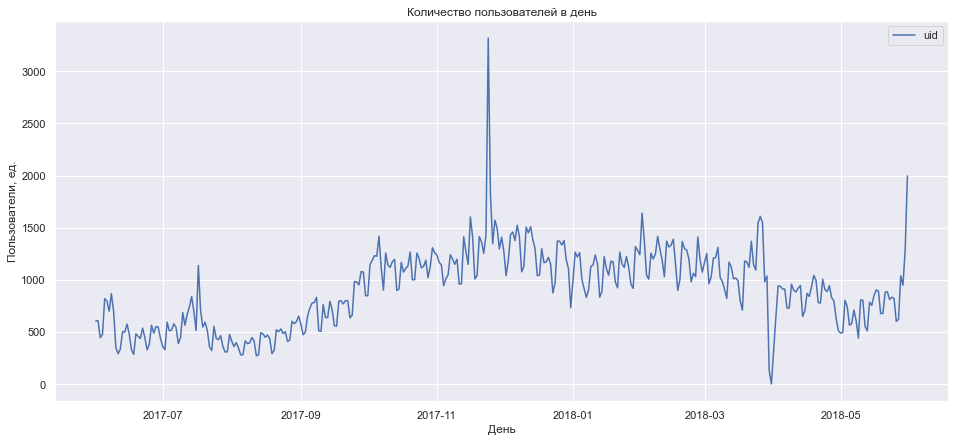

In [29]:
dau.plot(grid=True)
plt.title('Количество пользователей в день')
plt.xlabel('День')
plt.ylabel('Пользователи, ед.')

По дням пользователи показывают значение 500 летом, осенью увеличиваясь до 1000 и показывают скачок ближе к декабрю. После немного снижаются

Text(0, 0.5, 'Пользователи, ед.')

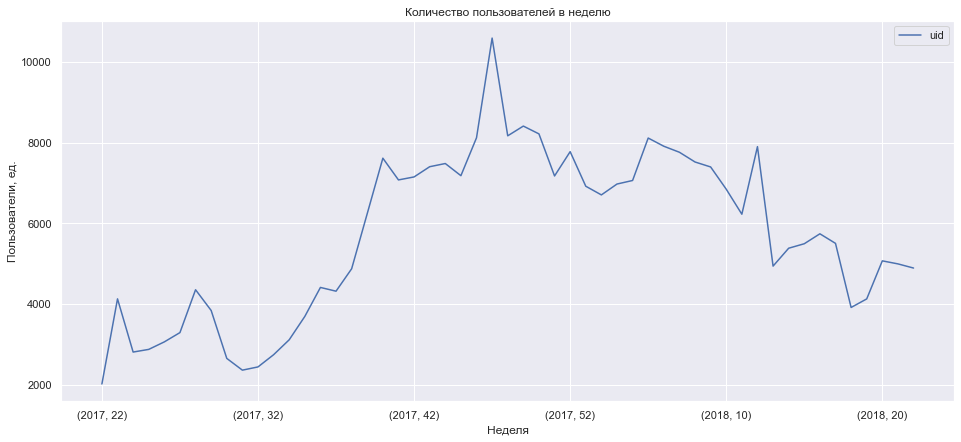

In [30]:
wau.plot(grid=True)
plt.title('Количество пользователей в неделю')
plt.xlabel('Неделя')
plt.ylabel('Пользователи, ед.')

Недельные показатели также говорят о росте пользователей к концу года

Text(0, 0.5, 'Пользователи, ед.')

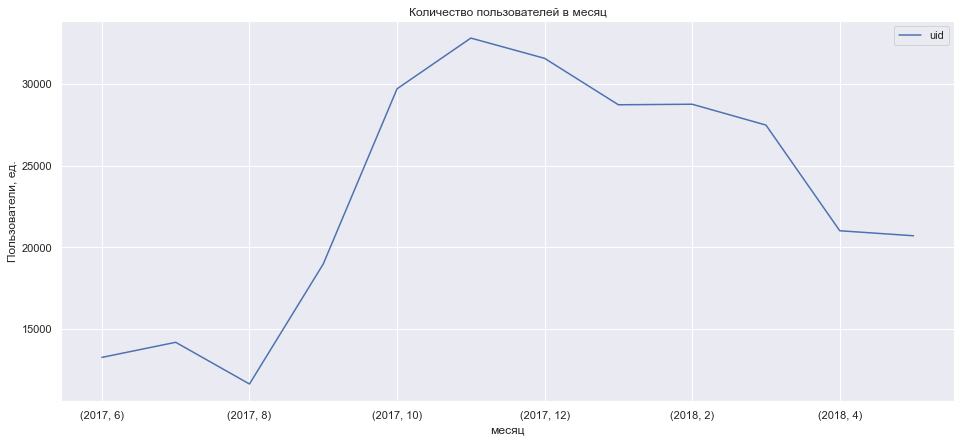

In [31]:
mau.plot(grid=True)
plt.title('Количество пользователей в месяц')
plt.xlabel('месяц')
plt.ylabel('Пользователи, ед.')

По месячным четко виден рост с августа (около 10000 пользователей) по ноябрь (около 35000 пользователей), с последующим снижением до 20000 пользователей к маю

**Промежуточный вывод**

Количество уникальных пользователей в месяц немного превышает 20 тыс. человек, при этом происходит скачок пользователей в конце ноября-начале декабря 2017 года

#### 3.1.2 Сколько раз в день пользователь в среднем заходит на сайт

Определим среднее количество сессий в день. 

In [32]:
count_date_session = visits.groupby('session_date').agg({'uid': 'count'}).mean()
print("Количество сессий в день {0:.2f} ".format(count_date_session[0]))

Количество сессий в день 987.36 


Определим сколько раз за день пользователи в среднем заходят на сайт, для этого разделим общее дневное число сессий на количество зашедших на сайт уникальных пользователей за день.

In [33]:
count_users_session = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()

sessions_per_user = count_date_session / count_users_session

In [34]:
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count', 'nunique']}).reset_index()
sessions_per_user.columns = ['session_date', 'n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])

In [35]:
users_sessions_mean = sessions_per_user['sessions_per_user'].mean()
print("Срднее количество сессий в день на одного ользователя - {0:.2f} ".format(users_sessions_mean))

Срднее количество сессий в день на одного ользователя - 1.08 


Text(0, 0.5, 'Сессии, ед.')

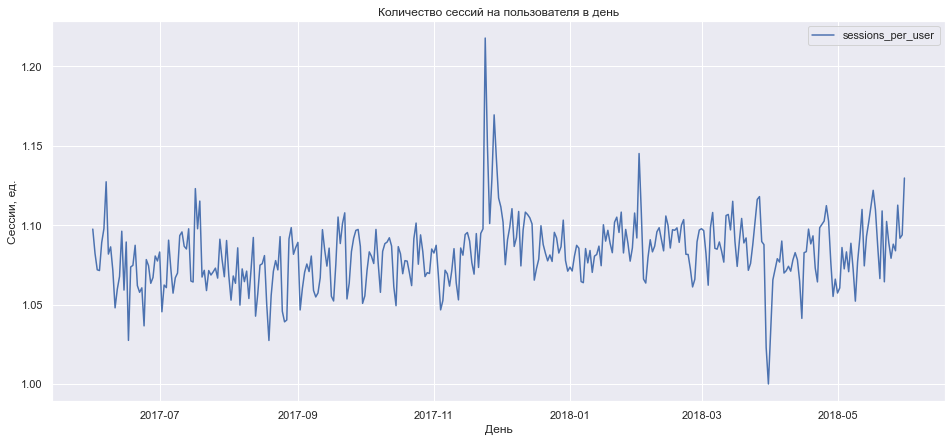

In [36]:
sessions_per_user.plot(x='session_date', y='sessions_per_user', kind='line', grid=True)
plt.title('Количество сессий на пользователя в день')
plt.xlabel('День')
plt.ylabel('Сессии, ед.')

Число сессий на пользователя немного превышает единицу со всплеском в конце ноября, начале декабря и падением в марте.

**Промежуточный вывод**

Рост количества сессий в начале месяца и всплеск в конце - может быть обусловлен заработной платой, которая тратится пользователями на развлечения

#### 3.1.3 Сколько времени пользователь проводит на сайте

In [37]:
visits['session_duration_min'] = (
    visits['session_end'] - visits['session_start']
).dt.seconds / 60
visits['session_duration_min'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_duration_min, dtype: float64

Одна сессия длится:

- В среднем 10 минут

- По медиане 5 минут

- По моде 1 минуту

In [38]:
visits['session_duration_min'].mode()

0    1.0
dtype: float64

Text(0.5, 1.0, 'Время проведенное на сайте (минуты)')

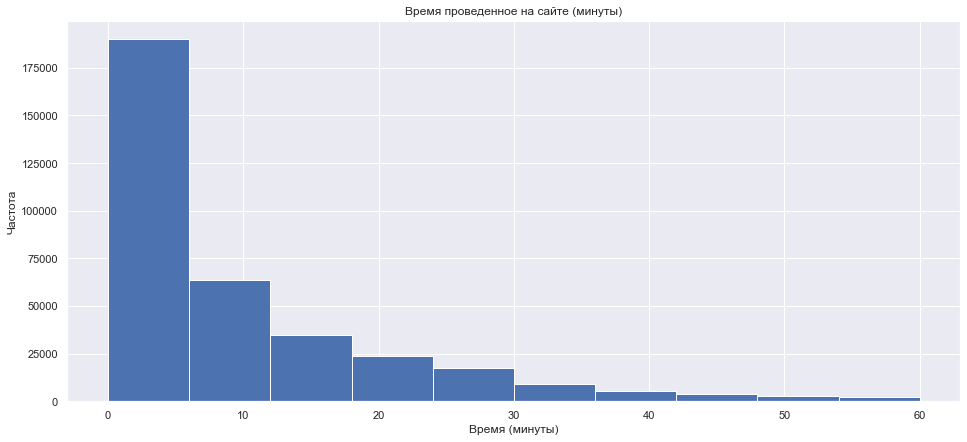

In [39]:
ax = visits['session_duration_min'].hist(bins=10, range=(0, 60))
ax.set_xlabel('Время (минуты)')
ax.set_ylabel('Частота')
ax.set_title('Время проведенное на сайте (минуты)')

Большая часть сессий проходят в пределах 10 минут. При этом, так как распределение не близко к нормальному, средняя мера определяется по моде, то есть 1 минута.

#### 3.1.4 Retention Rate (Индекс возврата)

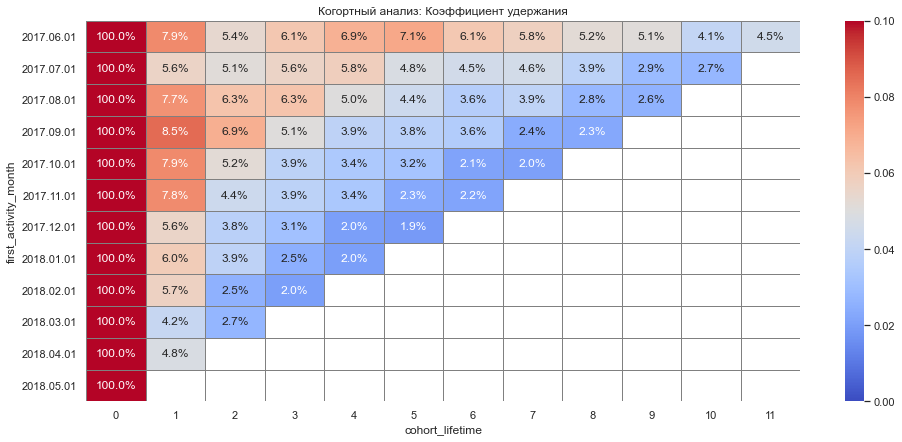

In [42]:
first_activity_date = visits.groupby('uid').agg({'session_start':'min'}).reset_index()
first_activity_date.columns = ['uid', 'first_activity_date']
visits = visits.merge(first_activity_date)

visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['session_start'].astype('datetime64[M]')
visits['cohort_lifetime'] = (visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

cohorts = visits.groupby(
    ['first_activity_month', 'cohort_lifetime']
).agg(
    {'uid': 'nunique'}
).reset_index()

initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_activity_month', 'uid']]

initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

cohorts = cohorts.merge(initial_users_count)
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(index='first_activity_month', columns='cohort_lifetime',
                                          values='retention', aggfunc='sum')

retention_pivot

sns.set(style='white')
plt.figure()
plt.title('Когортный анализ: Коэффициент удержания')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0, vmax = 0.1, 
                 cmap = 'coolwarm', yticklabels=retention_pivot.index.strftime('%Y.%m.%d'));

Процент удержания падает от месяца к месяцу, за редкими исключениями

In [43]:
second_cohort_retention = cohorts.query('cohort_lifetime == 1')['retention'].mean()
print("Среднее значение Retention Rate за второй месяц жизни когорт {0:.2f} ".format(second_cohort_retention))

Среднее значение Retention Rate за второй месяц жизни когорт 0.07 


### 3.2 Метрики электронной коммерции

#### 3.2.1 Время с первого посещения сайта до покупки

In [44]:
first_visit = visits.groupby('uid').agg({'session_start':'min'})\
                .rename(columns={'session_start':'first_visit_date'})\
                .reset_index()

first_order = orders.groupby('uid').agg({'purchase_time':'min'})\
                .rename(columns={'purchase_time':'first_purchase_date'})\
                .reset_index()

buying_time = first_visit.merge(first_order, on='uid', how='inner')

buying_time['buying_time'] = (buying_time['first_purchase_date'] - buying_time['first_visit_date']).dt.seconds / 60

buying_time['buying_time'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: buying_time, dtype: float64

In [45]:
buying_time['buying_time'].mode()

0    1.0
dtype: float64

Text(0.5, 1.0, 'Время от первого визита до покупки (минуты)')

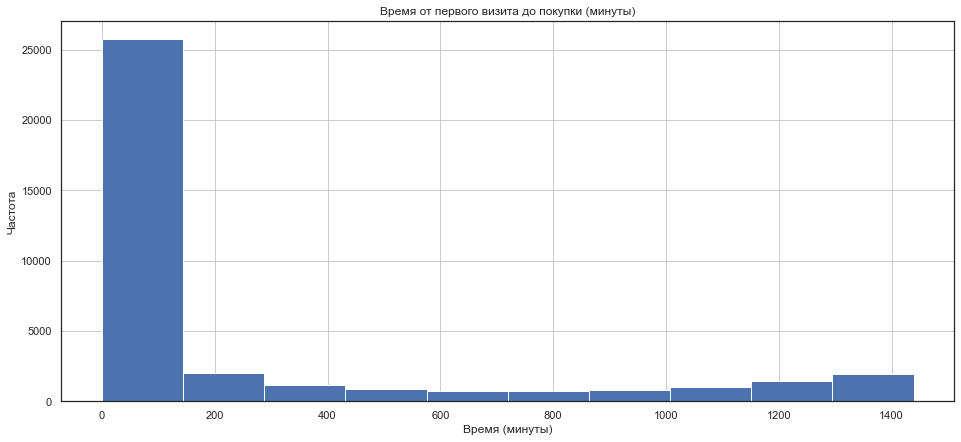

In [46]:
ax = buying_time['buying_time'].hist()
ax.set_xlabel('Время (минуты)')
ax.set_ylabel('Частота')
ax.set_title('Время от первого визита до покупки (минуты)')

Время от первого визиты до покупки:

- В среднем 249 минут

- По медиане 16 минут

- По моде 1 минута

В большинстве случаев покупка происходит в первые минут после начала сессии. Исходя из формы распределения (не близкое к нормальному), средней мерой является мода.

#### 3.2.2 Среднее количество покупок на одного покупателя

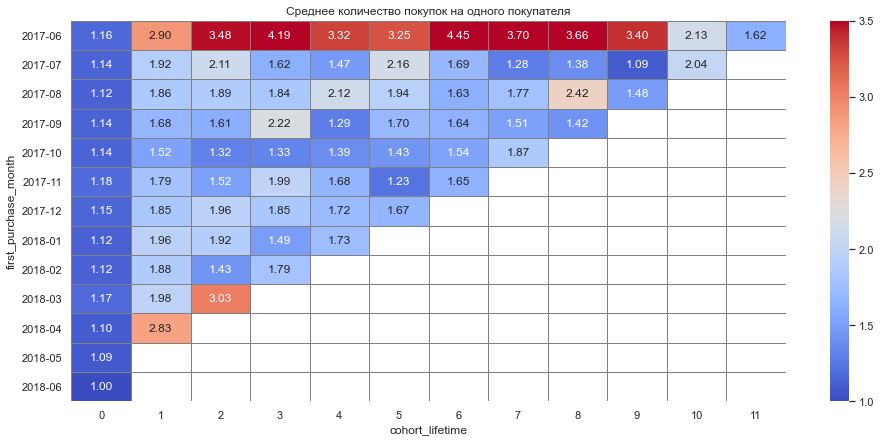

In [47]:
first_purchase_date = orders.groupby('uid').agg(
    {'purchase_time':'min'}
).rename(
    columns={'purchase_time':'first_purchase_date'}
)
orders_count = orders.merge(first_purchase_date, on='uid')
orders_count['first_purchase_month'] = orders_count['first_purchase_date'].astype('datetime64[M]')
orders_count['purchase_month'] = orders_count['purchase_time'].astype('datetime64[M]')
orders_count['cohort_lifetime'] = (
    orders_count['purchase_month'] - orders_count['first_purchase_month']
) / np.timedelta64(1, 'M')
orders_count['cohort_lifetime'] = orders_count['cohort_lifetime'].round().astype('int')
orders_count['first_purchase_month'] = orders_count['first_purchase_month'].dt.strftime('%Y-%m')
orders_grouped_by_cohorts = orders_count.groupby(
    ['first_purchase_month', 'cohort_lifetime']
).agg(
    {'purchase_month': 'count', 'uid': 'nunique'}
)
orders_grouped_by_cohorts['purchases_per_user'] = orders_grouped_by_cohorts['purchase_month'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
purchase_pivot = orders_grouped_by_cohorts.pivot_table(
    index='first_purchase_month',
    columns='cohort_lifetime',
    values='purchases_per_user')
purchase_pivot

purchase_pivot.cumsum(axis = 1).mean(axis = 0)
sns.set(style='white')
plt.figure()
plt.title('Среднее количество покупок на одного покупателя')
sns.heatmap(purchase_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap = 'coolwarm', vmin=1, vmax=3.5);

В целом количество покупок со временем может немного увеличиваться, но незначительно

In [48]:
mean_orders_per_user = orders_grouped_by_cohorts['uid'].count()/orders_grouped_by_cohorts['uid'].nunique()
print("Среднее значение числа покупок на одного пользователя {0:.2f} ".format(mean_orders_per_user))

Среднее значение числа покупок на одного пользователя 1.22 


**Промежуточный вывод**

Пользователи редко совершают вторую покупку, их что-то останавливает

#### 3.2.3 Средний чек

In [49]:
orders_and_visits = orders.merge(first_visit)
orders_and_visits['purchase_date'] = orders_and_visits['purchase_time'].dt.date
orders_and_visits['purchases_week'] = orders_and_visits['purchase_time'].dt.week
orders_and_visits['purchase_month'] = orders_and_visits['purchase_time'].dt.month

In [50]:
orders_and_visits['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Средний чек - 5 у.е.

In [51]:
mean_purchase_by_month = orders_and_visits.groupby('purchase_month').agg({'revenue': 'mean'})

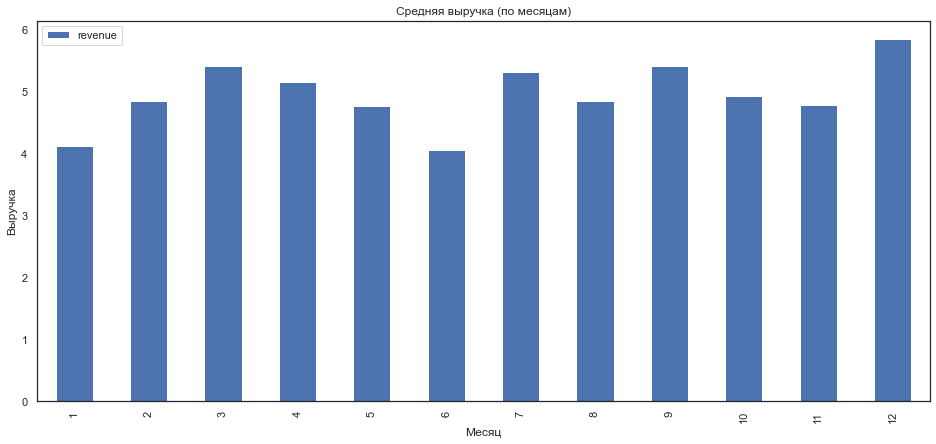

In [52]:
ax = mean_purchase_by_month.plot(kind='bar')
plt.title('Средняя выручка (по месяцам)')
ax.set_xlabel('Месяц')
ax.set_ylabel('Выручка')
plt.show()

Выручка колеблется от 4 до 6 тысяч, при этом декабрь самый прибыльный месяц

#### 3.2.4 LTV

In [53]:
orders['order_month'] = orders['purchase_time'].astype('datetime64[M]')

first_order = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_order.columns = ['uid', 'first_order_month']

cohort_sizes = first_order.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

orders_new = pd.merge(orders, first_order, on='uid')

cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [54]:
margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']

In [55]:
ltv_cohorts = report.groupby('first_order_month').agg({'ltv': 'sum'}).reset_index()

In [56]:
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output = output.cumsum(axis=1).round(2) 

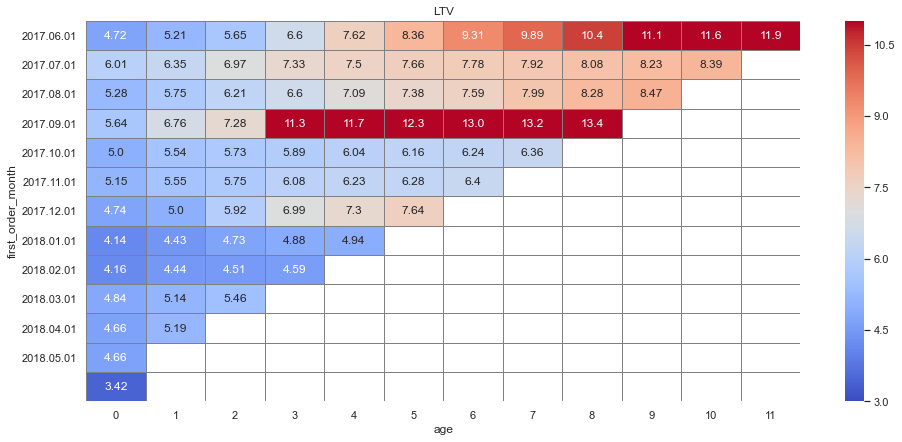

In [57]:
sns.set(style='white')
plt.figure()
plt.title('LTV')
sns.heatmap(output, annot=True, fmt='.3', linewidths=1, linecolor='gray', vmin = 3, vmax = 11, 
            cmap = 'coolwarm', yticklabels=retention_pivot.index.strftime('%Y.%m.%d'));

LTV со временем растет

In [58]:
report_six_month = report[report['first_order_month'] <= '2017-11-01']
report_six_month = report_six_month[report_six_month['age'] <= 6]

output_six_month = report_six_month.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output_six_month = output_six_month.cumsum(axis=1).round(2) 

ltv_six_month = report_six_month.groupby('first_order_month').agg({'ltv': 'sum'}).reset_index()
ltv_six_month_mean = ltv_six_month['ltv'].mean()
print("Среднее значение LTV за шесть месяцев {0:.2f} ".format(ltv_six_month_mean))

Среднее значение LTV за шесть месяцев 8.39 


### 3.3 Маркетинговые метрики

#### 3.3.1 Общая сумма расходов на маркетинг

In [50]:
marketing_costs = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
display(marketing_costs)

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [51]:
marketing_costs.sum()

source_id        34.00
costs        329131.62
dtype: float64

Суммарные расходы на маркетинг 329 131,62 у.е.

In [59]:
costs['month'] = costs['dt'].astype('datetime64[M]')
marketing_costs_by_month = costs.groupby(['source_id', 'month']).agg({'costs': 'sum'}).reset_index()

In [60]:
month_lst = ['Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', \
             'Декабрь', 'Январь', 'Февраль', 'Март', 'Апрель', 'Май']

In [61]:
costs_by_source_month = marketing_costs_by_month.groupby('source_id')['costs'].sum().reset_index()

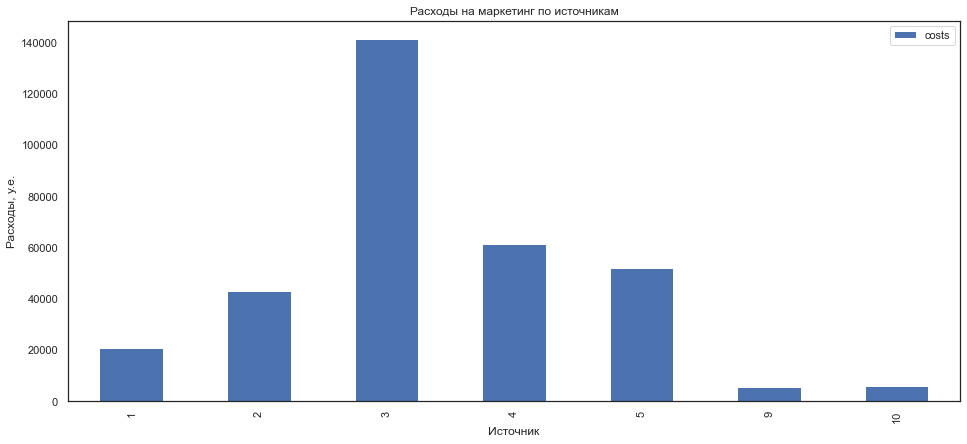

In [62]:
ax = costs_by_source_month.plot(x="source_id", y="costs", kind='bar')
plt.title('Расходы на маркетинг по источникам')
ax.set_xlabel('Источник')
ax.set_ylabel('Расходы, у.е.')
plt.show()

Самым дорогостоящим источником является 3, привышающий суммарные затраты на маркетинг по источникам 1, 2, 9 и 10

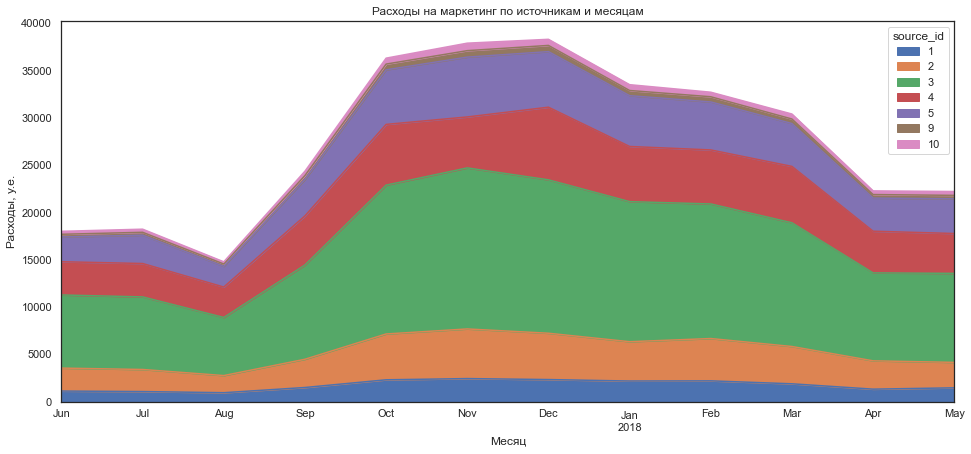

In [63]:
ax = marketing_costs_by_month.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')\
.plot(kind='area')
plt.title('Расходы на маркетинг по источникам и месяцам')
ax.set_xlabel('Месяц')
ax.set_ylabel('Расходы, у.е.')
plt.show()

Расходы на маркетинг составляют в сумме 329 131,62 и распределены по 7 источникам.
Самый затратный месяц декабрь, самый затратный источник - 3

#### 3.3.2 Средний CAC на одного покупателя

In [64]:
marketing_costs = marketing_costs_by_month.groupby('month')['costs'].sum().reset_index()

In [65]:
uid_count = orders.groupby('order_month')['uid'].nunique().reset_index()
uid_count.columns = ['order_month', 'uid_count']

In [66]:
report_costs = pd.merge(uid_count, marketing_costs, left_on='order_month', right_on='month', how='left')
report_costs['cac'] = (report_costs['costs'] / report_costs['uid_count']).round(2)

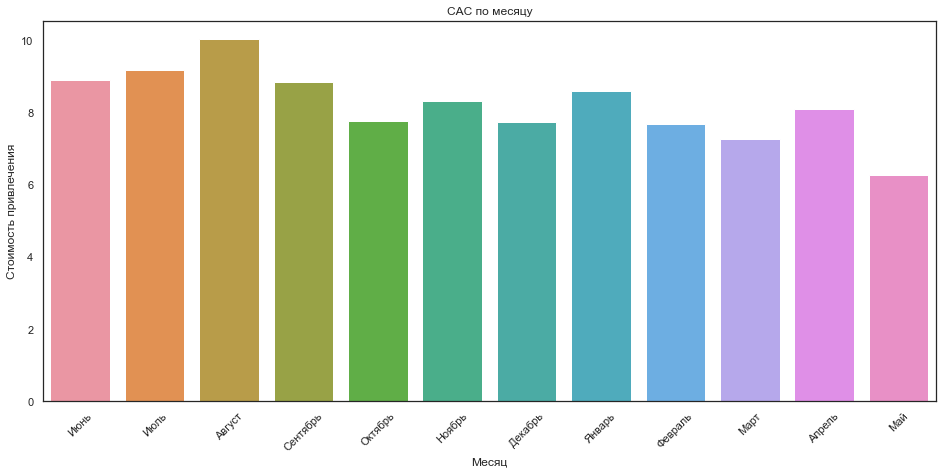

In [67]:
plt.figure()
ax = sns.barplot(x="month", y="cac", data=report_costs)
ax.set_xticklabels(month_lst, rotation=45)
plt.title('CAC по месяцу')
ax.set_xlabel('Месяц')
ax.set_ylabel('Стоимость привлечения')
plt.show()

Стоимость привлечения покупателя растёт, достигая своего пика в августе, далее плавно снижаясь с небольшими сплесками в ноябре, январе и апреле.

In [68]:
first_visit = visits.groupby(['uid'])['session_start'].min().reset_index()
first_visit.columns = ['uid', 'first_visit']
visits = visits.merge(first_visit)

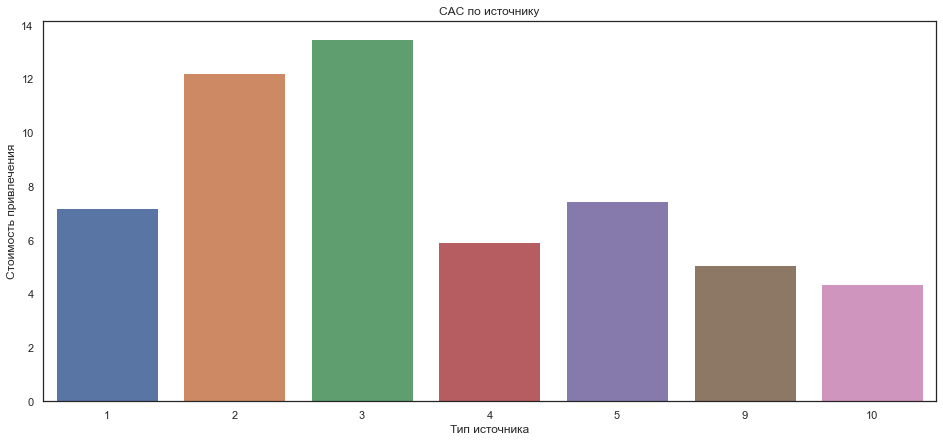

In [69]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()

visits_by_source = visits.query('session_start == first_visit')
customers_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'})\
                        .rename(columns={'uid':'customers'}).reset_index()

cac = customers_by_source.merge(costs_by_source, on='source_id').reset_index()
cac = cac.fillna(0)

cac['cac'] = cac['costs'] / cac['customers']
cac.sort_values('cac', ascending = False)

plt.figure()
ax = sns.barplot(x="source_id", y="cac", data=cac)
plt.title('CAC по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

Второй и третий источники имеют самую высокую стоимость привлечения, при этом третий источник требует самых больших расходов, а второй является 4 по затратности. Далее идут 1 и 5 источники, с близкими значениями затрат

In [70]:
cac_mean = cac['cac'].mean()
print('Средний CAC равняется: {0:.2f}'.format(cac_mean))

Средний CAC равняется: 7.96


#### 3.3.3 ROMI по когортам

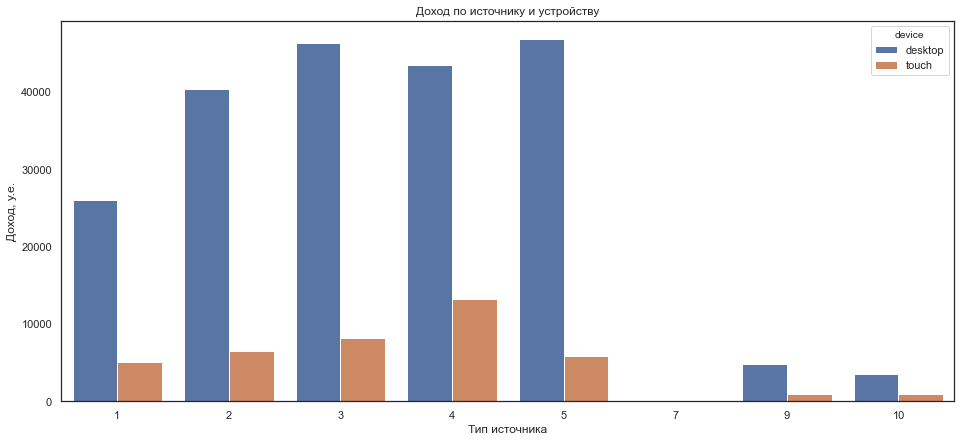

In [71]:
revenue_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'revenue':'sum'}).reset_index()

romi = revenue_by_source.merge(costs_by_source, on='source_id')
romi['romi'] = (romi['revenue'] - romi['costs']) / romi['costs']

revenue_by_source_and_device = (orders.merge(visits_by_source, on='uid', how='inner'))\
                                .groupby(['source_id', 'device']).agg({'revenue':'sum'}).reset_index()

plt.figure()
ax = sns.barplot(x="source_id", y="revenue", hue="device", data=revenue_by_source_and_device)
plt.title('Доход по источнику и устройству')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Доход, у.е.')
plt.show()

Прибыль от источников по девайсам:

- Компьютеры: наиболее прибыльными источникам являются 2, 3, 4, 5, с показателями более 40 тыс. у.е., далее идет источник 1 с показателем в 25 тыс. у.е., и отдельно выделяются источники 9 и 10 с прибылью около 5 тыс. у.е.

- Мобильные устройства: наиболее прибыльным источников является 4, с показателем в 13 тыс. у.е., далее идет группа из 1, 2, 3 и 5 с показателем от 5 до 7 тыс. у.е. и отдельно также 9 и 10 источники с показателями в 1 тыс. у.е.

In [72]:
romi.sort_values('romi', ascending = False)

,source_id,revenue,costs,romi
0,1,31090.55,20833.27,0.492351
1,2,46923.61,42806.04,0.096191
5,9,5759.40,5517.49,0.043844
4,5,52624.02,51757.10,0.016750
3,4,56696.83,61073.60,-0.071664
6,10,4450.33,5822.49,-0.235665
2,3,54511.24,141321.63,-0.614275


Источники 4, 10 и 3 имеют отрицательное значение рентабельности инвестиций в маркетинг, тем самым показывая свою несостоятельность. При этом наиболее прибыльным является 1 источник. 

# 4. Общий вывод

- **Краткий обзор проведенной работы:** была проведена небольшая предобработка данных, в целом их качество было удовлетворительно. Были рассчитаны продуктовые метрики, количество проведенного на сайте времени, проведен когортный анализ индекса возврата. Были рассчитаны метрики электронной коммерции - средний чек, среднее количество покупок, пожизненная ценность клиента. А также были рассчитаны маркетинговые метрики - стоимость привлечения клиента, коэффициент возврата маркетинговых инвестиций.
- **Главные выводы:** проводя анализ Яндекс.Афиши можно сказать, что мобильные устройства имеют очень низкие относительно компьютеров, показатели дохода. Особое внимание на источники 9 и 10 - нужно понять причины низкого дохода. Наиболее прибыльные источники 1, 2, 9 и 5. А наиболее финансово отягащающий источник 3, возможно по нему можно сократить расходы, не снижая CAC. В целом следует обратить больше внимания на мобильное приложение, почему по нему такой низкий доход, возможно неудобный интерфейс или множество багов - требуются дополнительные тесты. Наиболее доходные месяцы - конец осени-начало зимы, люди начинают приобретать подарки на Новый год, часто это могут быть билеты на мероприятия. Расходы на маркетинг достигают своего пика именно в декабре, при этом стоимость привлечений одного клиента в этом месяце ближе к нижней границе данного показателя - люди поддаются рекламе без особого сопративления. Несмотря на обилие летних фестивалей - лето остаётся мертвым сезоном относительно остальных. Также пользователи совершают покупки в течении первых минут пользования сервисом, но в основном числе не возвращаются за второй покупкой - следует изучить причины.